In [1]:
import pandas as pd
df = pd.read_csv('../input/Consumer_Complaints.csv')
df.head()

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,3/12/2014,Mortgage,Other mortgage,"Loan modification,collection,foreclosure",NaN,NaN,NaN,M&T BANK CORPORATION,MI,48382,NaN,NaN,Referral,3/17/2014,Closed with explanation,Yes,No,759217
1,10/1/2016,Credit reporting,NaN,Incorrect information on credit report,Account status,I have outdated information on my credit repor...,Company has responded to the consumer and the ...,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",AL,352XX,NaN,Consent provided,Web,10/5/2016,Closed with explanation,Yes,No,2141773
2,10/17/2016,Consumer Loan,Vehicle loan,Managing the loan or lease,NaN,I purchased a new car on XXXX XXXX. The car de...,NaN,"CITIZENS FINANCIAL GROUP, INC.",PA,177XX,Older American,Consent provided,Web,10/20/2016,Closed with explanation,Yes,No,2163100
3,6/8/2014,Credit card,NaN,Bankruptcy,NaN,NaN,NaN,AMERICAN EXPRESS COMPANY,ID,83854,Older American,NaN,Web,6/10/2014,Closed with explanation,Yes,Yes,885638
4,9/13/2014,Debt collection,Credit card,Communication tactics,Frequent or repeated calls,NaN,NaN,"CITIBANK, N.A.",VA,23233,NaN,NaN,Web,9/13/2014,Closed with explanation,Yes,Yes,1027760


In [2]:
df.shape

(903983, 18)

In [3]:
col = ['Product', 'Consumer complaint narrative']
df = df[col]
df = df[pd.notnull(df['Consumer complaint narrative'])]
df.columns = ['Categoria', 'Descripcion']
df.head()

,Categoria,Descripcion
1,Credit reporting,I have outdated information on my credit repor...
2,Consumer Loan,I purchased a new car on XXXX XXXX. The car de...
7,Credit reporting,An account on my credit report has a mistaken ...
12,Debt collection,This company refuses to provide me verificatio...
16,Debt collection,This complaint is in regards to Square Two Fin...


In [4]:
df.shape

(199970, 2)

In [5]:
df.Categoria.unique()

array(['Credit reporting', 'Consumer Loan', 'Debt collection', 'Mortgage',
       'Credit card', 'Other financial service',
       'Bank account or service', 'Student loan', 'Money transfers',
       'Payday loan', 'Prepaid card', 'Virtual currency',
       'Credit reporting, credit repair services, or other personal consumer reports',
       'Credit card or prepaid card', 'Checking or savings account',
       'Payday loan, title loan, or personal loan',
       'Vehicle loan or lease',
       'Money transfer, virtual currency, or money service'], dtype=object)

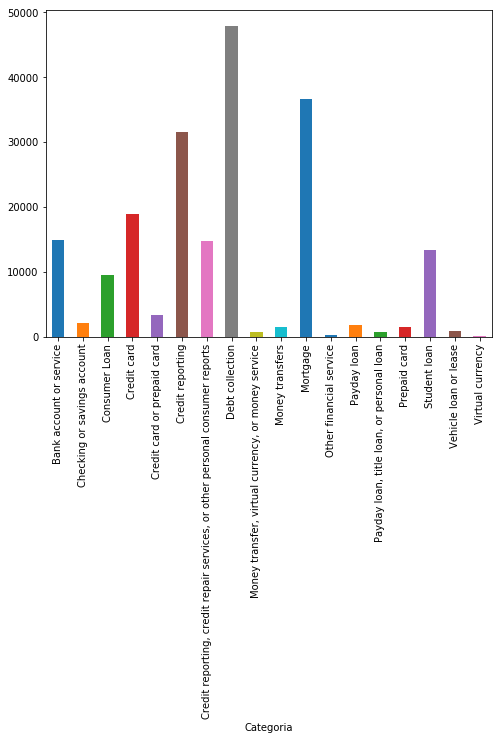

(18,)

In [6]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (8, 6))
df.groupby('Categoria').Descripcion.count().plot.bar(ylim = 0)
plt.show()
df.Categoria.unique().shape

In [7]:
df = df[(df.Categoria != 'Credit card or prepaid card') &
       (df.Categoria != 'Credit reporting, credit repair services, or other personal consumer reports') &
       (df.Categoria != 'Money transfer, virtual currency, or money service') &
       (df.Categoria != 'Payday loan, title loan, or personal loan')]

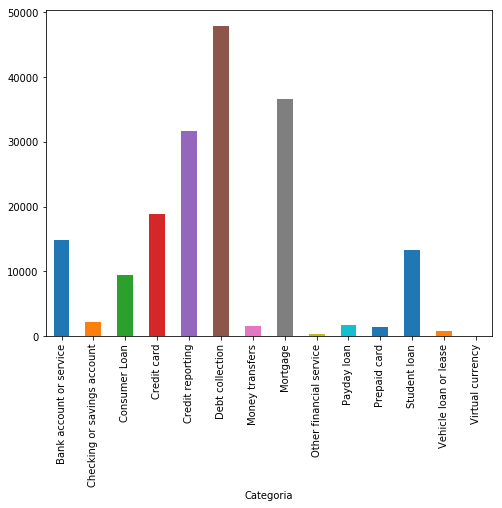

In [8]:
fig = plt.figure(figsize = (8, 6))
df.groupby('Categoria').Descripcion.count().plot.bar(ylim = 0)
plt.show()

In [9]:
df['categoria_id'] = df['Categoria'].factorize()[0]
df.head()

,Categoria,Descripcion,categoria_id
1,Credit reporting,I have outdated information on my credit repor...,0
2,Consumer Loan,I purchased a new car on XXXX XXXX. The car de...,1
7,Credit reporting,An account on my credit report has a mistaken ...,0
12,Debt collection,This company refuses to provide me verificatio...,2
16,Debt collection,This complaint is in regards to Square Two Fin...,2


In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer

bolsa_de_palabras = TfidfVectorizer(sublinear_tf = True, 
                        min_df = 5, 
                        norm = 'l2', 
                        encoding = 'latin-1',
                        ngram_range = (1, 2), 
                        stop_words = 'english')

val_descripcion = bolsa_de_palabras.fit_transform(df.Descripcion)
val_descripcion.shape

(180563, 389084)

In [11]:
val_categoria = df.categoria_id

In [12]:
categoria_id_df = df[['Categoria', 'categoria_id']].drop_duplicates().sort_values('categoria_id')
categoria_a_id = dict(categoria_id_df.values)
id_a_categoria = dict(categoria_id_df[['categoria_id', 'Categoria']].values)

In [13]:
from sklearn.feature_selection import chi2
import numpy as np

arreglo_temp = []

for Categoria, categoria_id in sorted(categoria_a_id.items()):
    palabras_chi2 = chi2(val_descripcion, val_categoria == categoria_id)
    indices = np.argsort(palabras_chi2[0])
    nombres_palabras = np.array(bolsa_de_palabras.get_feature_names())[indices]
    unigramas = [v for v in nombres_palabras if len(v.split(' ')) == 1]
    bigramas = [v for v in nombres_palabras if len(v.split(' ')) == 2]
    
    arreglo_temp.append((Categoria, unigramas[-3:], bigramas[-3:]))
    
uni_bi_categoria = pd.DataFrame(arreglo_temp, columns = ('categoria', 'unigrama', 'bigrama')) 
uni_bi_categoria

,categoria,unigrama,bigrama
0,Bank account or service,"[checking, bank, overdraft]","[debit card, overdraft fees, checking account]"
1,Checking or savings account,"[atm, deposit, app]","[active hours, use app, xxxx app]"
2,Consumer Loan,"[dealership, car, vehicle]","[vehicle xxxx, car loan, auto loan]"
3,Credit card,"[express, macy, card]","[annual fee, american express, credit card]"
4,Credit reporting,"[transunion, experian, equifax]","[equifax xxxx, trans union, credit report]"
5,Debt collection,"[collect, collection, debt]","[debt collection, collect debt, collection age..."
6,Money transfers,"[paypal, moneygram, western]","[money gram, money transfer, western union]"
7,Mortgage,"[escrow, modification, mortgage]","[short sale, mortgage company, loan modification]"
8,Other financial service,"[fedloanhelp, certegy, lexington]","[client solutions, global client, lexington law]"
9,Payday loan,"[castle, ace, payday]","[picture loans, big picture, payday loan]"


In [14]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(val_descripcion, 
                                                    val_categoria, 
                                                    test_size = 0.3, 
                                                    random_state = 0)

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
import time

modelos = [
    LogisticRegression(),
    MultinomialNB(),
    LinearSVC()
]

cross_val = 5
cross_val_df = pd.DataFrame(index = range(cross_val * len(modelos)))
arreglo_temp = []

for modelo in modelos:
    nombre_modelo = modelo.__class__.__name__
    start_time = time.time()
    exactitudes = cross_val_score(modelo, X_train, y_train, scoring = 'accuracy', cv = cross_val)
    print("'{}' - {} seg".format(modelo.__class__.__name__, round((time.time() - start_time),2)))
    for fold_idx, accuracy in enumerate(exactitudes):
        arreglo_temp.append((nombre_modelo, fold_idx, accuracy))
        
cross_val_df = pd.DataFrame(arreglo_temp, columns = ['nombre_modelo', 'fold_idx', 'exactitud'])

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


'LogisticRegression' - 399.71 seg
'MultinomialNB' - 6.02 seg
'LinearSVC' - 90.45 seg


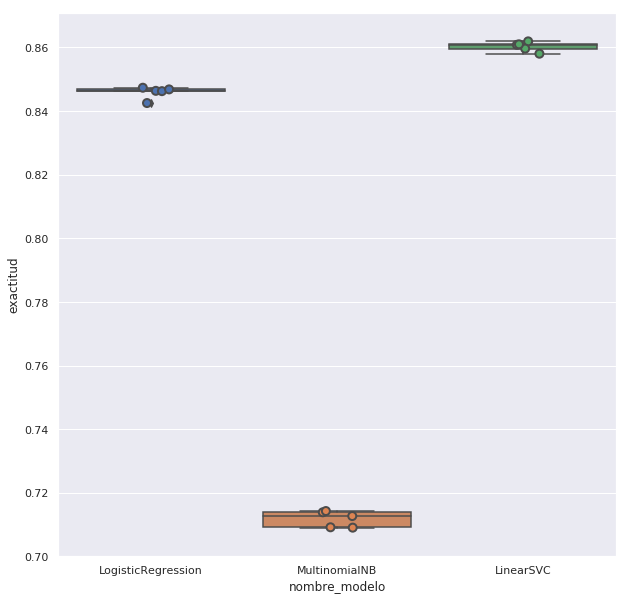

In [16]:
import seaborn as sns

sns.set(rc={'figure.figsize':(10,10)})
sns.boxplot(x = 'nombre_modelo', y = 'exactitud', data = cross_val_df)
sns.stripplot(x = 'nombre_modelo', y = 'exactitud', data = cross_val_df, size = 8, jitter = True, edgecolor = "gray", linewidth = 2)

plt.show()

In [17]:
cross_val_df.groupby('nombre_modelo').exactitud.mean()

nombre_modelo
LinearSVC             0.860294
LogisticRegression    0.845879
MultinomialNB         0.711862
Name: exactitud, dtype: float64

In [18]:
model = LinearSVC()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

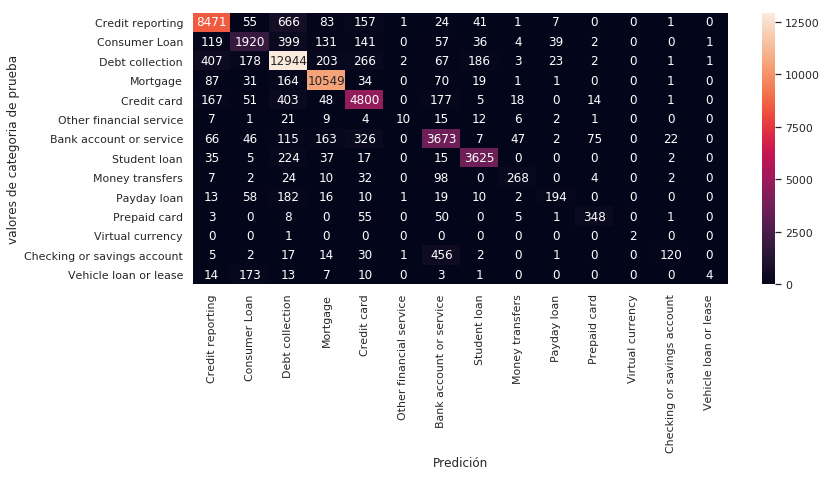

In [19]:
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_test, y_pred)
plt.subplots(figsize = (12, 5))
sns.heatmap(conf_mat, 
            annot = True, 
            fmt = 'd', 
            xticklabels = categoria_id_df.Categoria.values, 
            yticklabels = categoria_id_df.Categoria.values)
plt.ylabel('valores de categoria de prueba')
plt.xlabel('Predición')
plt.show()

In [20]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred, target_names=df['Categoria'].unique()))

                             precision    recall  f1-score   support

           Credit reporting       0.90      0.89      0.90      9507
              Consumer Loan       0.76      0.67      0.71      2849
            Debt collection       0.85      0.91      0.88     14283
                   Mortgage       0.94      0.96      0.95     10957
                Credit card       0.82      0.84      0.83      5684
    Other financial service       0.67      0.11      0.19        88
    Bank account or service       0.78      0.81      0.79      4542
               Student loan       0.92      0.92      0.92      3960
            Money transfers       0.75      0.60      0.67       447
                Payday loan       0.72      0.38      0.50       505
               Prepaid card       0.78      0.74      0.76       471
           Virtual currency       1.00      0.67      0.80         3
Checking or savings account       0.79      0.19      0.30       648
      Vehicle loan or lease      